# Example notebook: Spliced Binned-Pareto distribution fitted using a DistributionalTCN

This notebook is an example how to
(a) use a DistributionalTCN to fit a Spliced Binned-Pareto distribution to given data, and 
(b) compare the Spliced Binned-Pareto distribution fit to other distributions' fits.

1. [Library imports](#imports)
1. [Data Generation](#data)
1. [Train a Distributional TCN](#tcn)
    1. (new) Spliced Binned-Pareto distribution
    1. Binned distribution
    1. Gaussian distribution
1. [Evaluation: Probability-Probability plots on test data](#pp)



<div style="text-align: right"> Total Runtime (1 gpu): 30 minutes </div>


## Library Imports <a name="imports"></a>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import os
import random
from scipy import stats
import time
from tqdm import tqdm, trange

import torch
from torch import optim

from spliced_binned_pareto import SplicedBinnedPareto, Binned
from distr_tcn import DistributionalTCN
from gaussian_model import GaussianModel
from training_functions import train_step_from_batch, eval_on_series, plot_prediction, highlight_min
from data_functions import create_ds, create_ds_asymmetric

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)



###########################
# Get device information
###########################
cuda_id = '0'
if torch.cuda.is_available():  
    dev = f"cuda:{cuda_id}" 
else:
    dev = "cpu"
device = torch.device(dev) 
print('Device is', device)


# Reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)



Device is cpu


## Data Generation <a name="data"></a>

Here we generate time series with a sinusoidal mean, and asymmetric heavy-tailed noise.

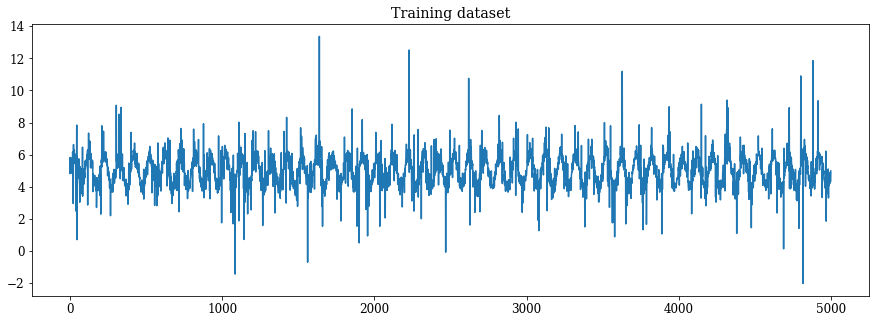

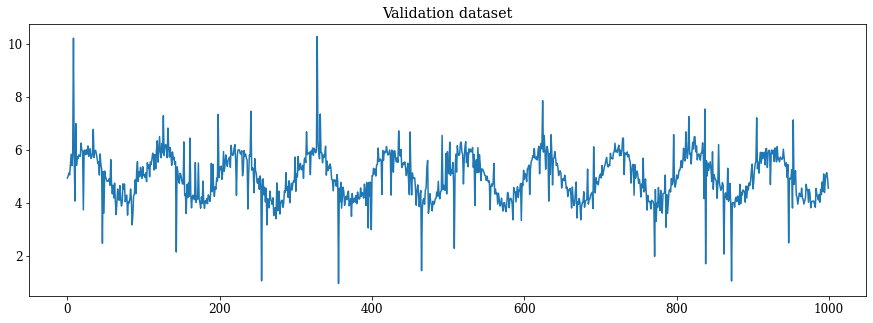

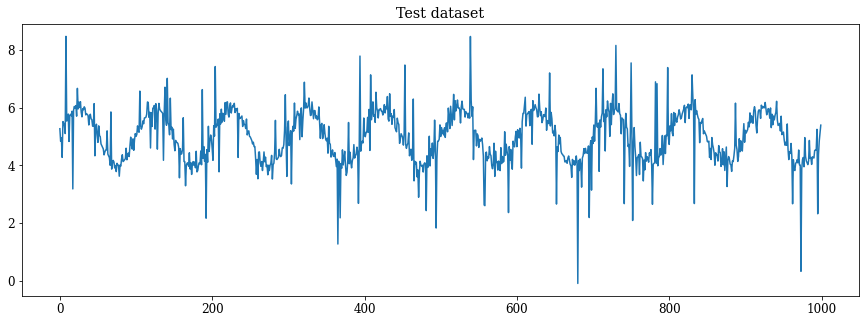

In [3]:
t_dof = [10, 10]
noise_mult = [0.25, 0.25]
xi =[1/50., 1/25.]

train_ts_tensor = create_ds_asymmetric(5_000, t_dof, noise_mult, xi)
val_ts_tensor = create_ds_asymmetric(1_000, t_dof, noise_mult, xi)
test_ts_tensor = create_ds_asymmetric(1_000, t_dof, noise_mult, xi)

train_ts_tensor = train_ts_tensor.to(device)
val_ts_tensor = val_ts_tensor.to(device)
test_ts_tensor = test_ts_tensor.to(device)

plt.figure(figsize=(15,5))
plt.plot(train_ts_tensor.cpu().flatten())
plt.title('Training dataset')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(val_ts_tensor.cpu().flatten())
plt.title('Validation dataset')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test_ts_tensor.cpu().flatten())
plt.title('Test dataset')
plt.show()



## Train a Distributional TCN <a name="tcn"></a>

Here we design a Distributional Temporal Convolution Network (DistributionalTCN) to learn the one-step ahead (lead_time) predictive distribution from the series' previous 100 observations (context_length). We use the DistributionalTCN to compare the fits of 3 predictive distributions: Spliced Binned-Pareto, Binned, and Gaussian.

| Distribution      | Avg Time | Approx Total Time (1 gpu) | 
| ----------- | ----------- | ----------- |
| Spliced Binned-Pareto      | 40s/epoch       | 12 min       |
| Binned   | 40s/epoch        | 12 min       |
| Gaussian   | 3s/epoch        | 2 min       |

In [4]:
context_length = 100
lead_time = 1

# Defining the main hyperparameters
bins_upper_bound = train_ts_tensor.max()
bins_lower_bound = train_ts_tensor.min()
nbins = 100
percentile_tail = 0.05
tcn_layers = 4


[Spliced Binned-Pareto]:   0%|          | 0/1 [00:00<?, ?it/s]

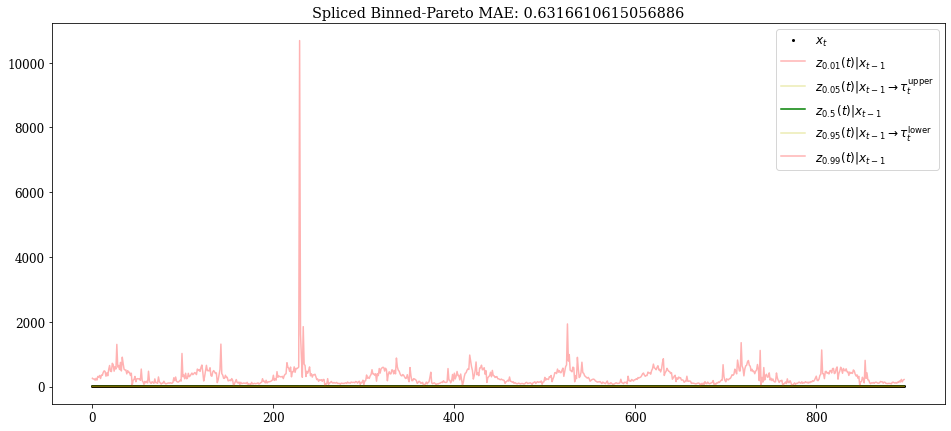

[Spliced Binned-Pareto] Train loss: 3.393, Val loss: 2.556: 100%|██████████| 1/1 [00:23<00:00, 23.77s/it]


runtime: 23.781893968582153


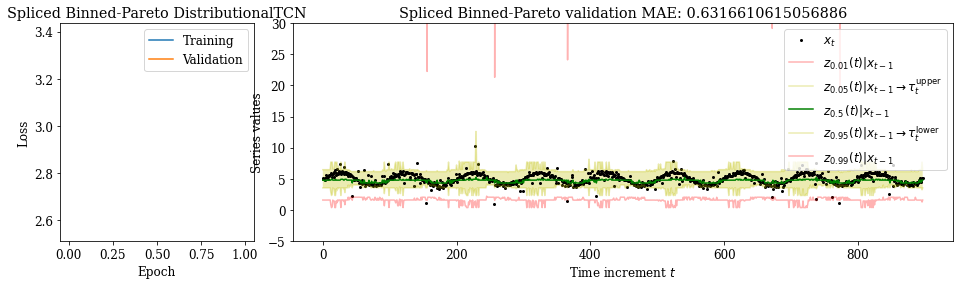

[Binned] Train loss: 6.030, Val loss: 4.342: 100%|██████████| 1/1 [00:12<00:00, 12.97s/it]


runtime: 12.991041898727417


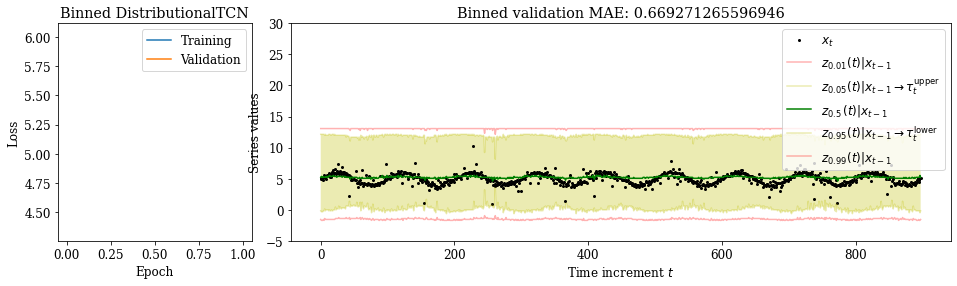

[Gaussian] Train loss: 13.867, Val loss: 13.669: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


runtime: 4.136697769165039


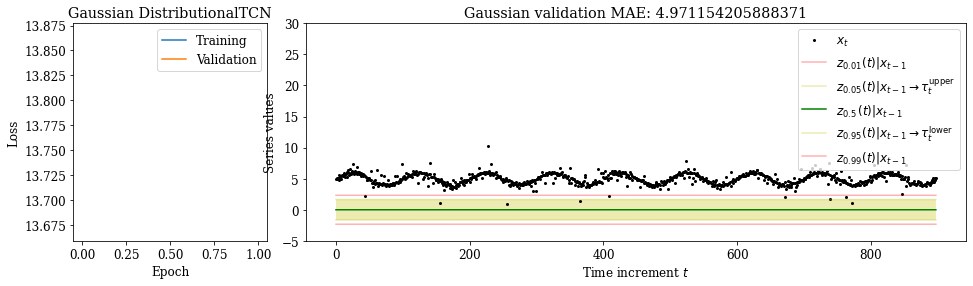

In [5]:
title_methods = ['Spliced Binned-Pareto', 'Binned', 'Gaussian']

dict_storage = dict(zip(
    list(map(lambda x: x.lower().replace(' ','').replace('-','') , title_methods)), 
    [dict(), dict(), dict()]
))


for title_method in title_methods:
    method_str = title_method.lower().replace(' ','').replace('-','')

    ####################################################################################
    # Specifying the predictive output distribution
    ####################################################################################
    if method_str == 'splicedbinnedpareto':

        spliced_binned_pareto_distr = SplicedBinnedPareto(
                        bins_lower_bound=bins_lower_bound,
                        bins_upper_bound=bins_upper_bound,
                        nbins=nbins,
                        percentile_gen_pareto = torch.tensor(percentile_tail),
                        validate_args=None
        )
        spliced_binned_pareto_distr.to_device(device)

        output_distribution = spliced_binned_pareto_distr
        output_channels = nbins + 4


    if method_str == 'binned':

        binned_distr = Binned(
                          bins_lower_bound=bins_lower_bound,
                          bins_upper_bound=bins_upper_bound,
                          nbins=nbins,
                          validate_args=None)
        binned_distr.to_device(device)

        output_distribution = binned_distr
        output_channels = nbins


    if method_str == 'gaussian':

        gaussian_distr = GaussianModel(mu=torch.tensor(0.), sigma=torch.tensor(1.), device=device)
        gaussian_distr.to_device(device)

        output_distribution = gaussian_distr
        output_channels = 2

        
    ####################################################################################
    # Creating the Distributional TCN
    ####################################################################################
    distr_tcn = DistributionalTCN(
        in_channels=1,  # channels in the time series (univariate)
        out_channels=output_channels,  # channels in the time series (num parameters)
        kernel_size=3,
        channels=3,  # channels inside the TCN, keep equal to out_channels for simplicity, expand for better performance
        layers=tcn_layers,  # number of TCN blocks
        output_distr=output_distribution,
    )
    distr_tcn.to(device)
    distr_tcn = distr_tcn.float()


    ####################################################################################
    # Training TCN for predictive distribution:
    ####################################################################################
    learning_rate = 0.0002 
    optimizer = optim.Adam(params=distr_tcn.parameters(), lr=learning_rate)

    ts_len = train_ts_tensor.shape[2]
    val_ts_len = val_ts_tensor.shape[2]
    epochs = 1
    epoch_mod = 1

    train_losses = []
    val_losses = []
    predictions_list = []

    dict_storage[method_str] = dict(((k, eval(k)) for k in ('method_str', 'title_method', 'learning_rate', 'epochs', 'context_length', 'lead_time')))
    
    
    ####################################################################################
    # Train model
    # Running a DistributionalTCN on data
    ####################################################################################
    start = time.time()
    
    t = trange(epochs, desc=f'[{title_method}]', leave=True)
    for epoch in t:

        log_loss_train = eval_on_series(distr_tcn, optimizer, train_ts_tensor, ts_len, context_length, is_train=True, return_predictions=False, lead_time=lead_time)
        epoch_train_loss = np.mean(log_loss_train)
        train_losses.append(epoch_train_loss)


        if epoch % epoch_mod == 0:
            log_loss_val, epoch_predictions = eval_on_series(distr_tcn, optimizer, val_ts_tensor, val_ts_len, context_length, is_train=False, return_predictions=True, lead_time=lead_time)
            predictions_list.append(epoch_predictions)
            epoch_val_loss = np.mean(log_loss_val)
            val_losses.append(epoch_val_loss)

            if method_str == 'splicedbinnedpareto': # No need to plot validation updates for all methods; demonstrate for one
                plot_prediction(val_ts_tensor, predictions_list[-1], context_length, lead_time, end=1500)
                title = plt.gca().get_title();
                title = title_method + ' MAE: ' + title
                plt.title(title);
                plt.show()


            t.set_description(f'[{title_method}] Train loss: {epoch_train_loss:.3f}, Val loss: {epoch_val_loss:.3f}')
            t.refresh()



    end = time.time()
    print('runtime:', end-start)
    dict_storage[method_str]['runtime'] = end-start
    dict_storage[method_str]['distr_tcn'] = distr_tcn

    
    ####################################################################################
    # Plot losses
    ####################################################################################
    fig = plt.figure(figsize=[16,4])
    spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)

    f_ax1 = fig.add_subplot(spec[0, 0])
    plt.plot(train_losses, label='Training')
    plt.plot(epoch_mod+epoch_mod*np.arange(len(val_losses)), [i for i in val_losses], label='Validation' )
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title_method} DistributionalTCN')
    
    ####################################################################################
    # Plot of distribution fit on validation data 
    ####################################################################################
    f_ax2 = fig.add_subplot(spec[0, 1:])
    fig = plot_prediction(val_ts_tensor, predictions_list[-1], context_length, lead_time, start=0, end=val_ts_len, fig=f_ax2)
    title = plt.gca().get_title();
    plt.ylim(-5.0, 30.0);
    plt.xlabel(f'Time increment $t$')
    plt.ylabel(r'Series values')
    plt.ylim(-5.0, 30.0);
    title = title_method + ' validation MAE: ' + title
    plt.title(title);
    plt.show()

## Evaluation: Probability-Probability plots on test data <a name="pp"></a>

We evaluate the accuracy of the density estimation of each of the method using Probability-Probability (PP) plots (PP-plots). For a given quantile level $q$, we compute $ y_q$ the fraction of points that fell below the given quantile $z_q{(t)} $ of their corresponding predictive distribution:
\begin{align}
  y_q = \frac{\sum_{t=2}^{T} \mathbb{I}[ {x}_t < z_{1-q}{(t)} ] }{T}, \hspace{40pt}   z_q{(t)} : p\left( {x}_{t} > z_q{(t)} \middle| {x}_{1:t-1} \right)< q
\end{align}
To obtain a quantitative score, we measure how good the tail estimate is by computing the Mean Absolute Error (MAE) between  $y_q $ and $q $ for all measured quantiles $q$.



In [6]:
def quantile_to_str(q):
    """
    Quick function to cast quantile decimal to q-prefixed string
    """
    return 'q-'+str(np.round(q,3))

lower_tail_end = percentile_tail
upper_tail_start = 1-percentile_tail

likelihoods_of_interest = np.linspace(0.001, lower_tail_end, 25)
quantile_levels = torch.tensor(np.unique(np.round(np.concatenate((likelihoods_of_interest, np.linspace(lower_tail_end, upper_tail_start, 81), 1-likelihoods_of_interest)), 3)))
quantile_strs = list(map(quantile_to_str, quantile_levels.numpy()))
quantile_levels = quantile_levels.to(torch.device(dev))

In [7]:
ts_out_tensor = test_ts_tensor.float()
ts_len = ts_out_tensor.shape[2]
data_out = dict(
        time=np.arange(ts_out_tensor.shape[-1]+lead_time),
        ts=np.concatenate((ts_out_tensor.cpu().squeeze(), np.array([np.nan]*lead_time))),
)


for method_str in list(dict_storage.keys()):
    
    # Get the stored DistributionTCN fitted for the given method
    distr_tcn = dict_storage[method_str]['distr_tcn']
    title_method = dict_storage[method_str]['title_method']
    
    data_out[method_str] = dict()
    for q_str in quantile_strs:
        data_out[method_str][q_str] = [np.nan]*(context_length+2)

    # Loop through the time series
    t = trange(ts_len - context_length - lead_time, desc=title_method, leave=True)
    start = time.time()
    for i in t:

        ts_chunk = ts_out_tensor[:, :, i:i+context_length]
        distr_output = distr_tcn(ts_chunk)

        # z_q(t) quantile of predictive distribution
        quantile_values = distr_output.icdf(quantile_levels)
        for qs, qv in zip(quantile_strs, quantile_values):
            data_out[method_str][qs].append( qv.item() )
            
        if i==t.total-1:
            t.set_description(f'[{title_method}] runtime {int(time.time()-start)}s')
            t.refresh()

    # y_q fraction of points below z_q(t)
    calibration_pairs = []
    for qs, ql in zip(quantile_strs, quantile_levels.cpu().numpy()):
        proportion_observations = np.array(list(map(lambda x: x[0]< x[1], zip(data_out['ts'], data_out[method_str][qs]) ))).sum() / np.sum(np.isfinite(np.array(data_out[method_str][qs])))
        calibration_pairs.append([ql, proportion_observations])
    calibration_pairs = np.array(calibration_pairs)
    data_out[method_str]['calibration'] = calibration_pairs



[Gaussian] runtime 2s: 100%|██████████| 899/899 [00:02<00:00, 323.81it/s]


,Lower tail,Base,Upper tail,Full distribution
Spliced Binned-Pareto,0.003180,0.098478,0.021033,0.065097
Binned,0.024268,0.105959,0.023397,0.074515
Gaussian,0.024500,0.498957,0.968594,0.498050


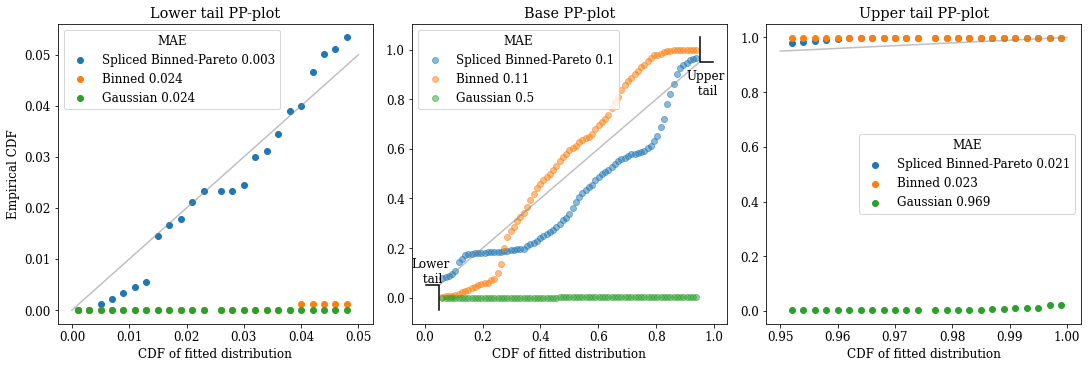

In [8]:
fig = plt.figure(figsize=[15,5], constrained_layout=True)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
mae_table = pd.DataFrame([], columns=['Lower tail','Base','Upper tail','Full distribution'], index=title_methods)

# Lower tail
start = 0.0
end = lower_tail_end
indices = quantile_levels.cpu().numpy() > start 
indices *= quantile_levels.cpu().numpy() < end

f_ax1 = fig.add_subplot(spec[0, 0])
alpha = 0.5
plt.plot(np.linspace(start,end), np.linspace(start,end), color='gray', alpha=alpha, label=None)
for method_str in list(dict_storage.keys()):
    calibration_pairs = data_out[method_str]['calibration']
    mae = np.mean(np.abs(np.diff(calibration_pairs[indices,:])))
    title_method = dict_storage[method_str]['title_method']
    mae_table.loc[title_method, 'Lower tail'] = mae
    plt.scatter(calibration_pairs[indices,0], calibration_pairs[indices,1], label=f'{title_method} {np.round(mae,3)}')
plt.legend(title='MAE')
plt.xlabel(f'CDF of fitted distribution');
plt.ylabel('Empirical CDF'); # Proportion of data below quantile');
plt.title('Lower tail PP-plot');

# Base distribution
start = lower_tail_end
end = upper_tail_start
indices = quantile_levels.cpu().numpy() > start 
indices *= quantile_levels.cpu().numpy() < end

f_ax1 = fig.add_subplot(spec[0, 1])
alpha = 0.5
plt.plot(np.linspace(start,end), np.linspace(start,end), color='gray', alpha=alpha, label=None)
for method_str in list(dict_storage.keys()):
    calibration_pairs = data_out[method_str]['calibration']
    mae = np.mean(np.abs(np.diff(calibration_pairs[indices,:])))
    title_method = dict_storage[method_str]['title_method']
    mae_table.loc[title_method, 'Base'] = mae
    plt.scatter(calibration_pairs[indices,0], calibration_pairs[indices,1], alpha=alpha, label=f'{title_method} {np.round(mae,2)}')
plt.legend(title='MAE')
xlim, ylim = plt.xlim(), plt.ylim()
plt.plot([xlim[0], lower_tail_end, lower_tail_end], [lower_tail_end, lower_tail_end, ylim[0]], color='black', label=None)
plt.text(0.02, lower_tail_end, 'Lower\n tail', ha='center', va='bottom')
plt.plot([upper_tail_start, upper_tail_start, xlim[1]], [ylim[1], upper_tail_start, upper_tail_start], color='black', label=None)
plt.text((xlim[1]-upper_tail_start)/2+upper_tail_start, upper_tail_start-0.03, 'Upper\n tail', ha='center', va='top')
plt.xlabel(f'CDF of fitted distribution');
plt.title('Base PP-plot');


# Upper tail
start = upper_tail_start
end = 1
indices = quantile_levels.cpu().numpy() > start 
indices *= quantile_levels.cpu().numpy() < end

f_ax2 = fig.add_subplot(spec[0, 2])
plt.plot(np.linspace(start,end), np.linspace(start,end), color='gray', alpha=alpha, label=None)
for method_str in list(dict_storage.keys()):
    calibration_pairs = data_out[method_str]['calibration']
    mae = np.mean(np.abs(np.diff(calibration_pairs[indices,:])))
    title_method = dict_storage[method_str]['title_method']
    mae_table.loc[title_method, 'Upper tail'] = mae
    plt.scatter(calibration_pairs[indices,0], calibration_pairs[indices,1], label=f'{title_method} {np.round(mae,3)}')
plt.legend(title='MAE')
plt.xlabel(f'CDF of fitted distribution');
plt.title('Upper tail PP-plot');
# plt.show()


# Whole distribution
for method_str in list(dict_storage.keys()):
    calibration_pairs = data_out[method_str]['calibration']
    mae = np.mean(np.abs(np.diff(calibration_pairs)))
    title_method = dict_storage[method_str]['title_method']
    mae_table.loc[title_method, 'Full distribution'] = mae

    
# Highlight the method row that achieves the minimum error for each column
display(mae_table.style.set_caption("Mean Absolute Error (MAE)").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('font-size', '16px')
    ]
}]).apply(highlight_min))
print('\n\n\n')